# DiploDatos 2019 - Análisis de Series Temporales

## Integrantes

| Nombre | e-mail |
|------|------|
|Rivadero, Isabel | isarivadero@hotmail.com |
|Vargas, Miguel | lvc0107@protonmail.com |
|Mancuso, Fernando | manquius@gmail.com |

## Práctico de Introducción al aprendizaje automático

En este práctico no introduciremos en las primeras herramientas de aprendizaje
automático. Diseñaremos e implementaremos algunos modelos simples y definir métricas
para ver como performan.

### Dataset

In [144]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(rc={'figure.figsize':(10,6)})

cols = ['service',
        'sender_zipcode',
        'receiver_zipcode',
        'sender_state',
        'receiver_state',
        'shipment_type',
        'quantity',
        'status',
        'date_created',
        'date_sent',
        'date_visit',
        'target']
cols_holidays = ['holiday', 
                 'description']
data_path = './shipments_BR_201903.csv'
holidays = './holidays.csv'

#### Referencia de las columnas
* **service**: Identificador unico que corresponde a un tipo de servicio de un correo en particular.
* **sender_zipcode:** Código postal de quien envía el paquete (usualmente el vendedor).
* **receiver_zipcode:** Código postal de quien recibe el paquete (usualmente el comprador).
* **sender_state:** Nombre abreviado del estado de quien envía el paquete.
* **receiver_state:** Nombre abreviado del estado de quien recibe el paquete.
* **quantity:** Cantidad de items que tiene dentro el paquete.
* **status:** Estado final del envío.
* **date_created:** Fecha de compra de el o los items.
* **date_sent:** Fecha en que el correo recibe el paquete.
* **date_visit:** Fecha en que el correo entrega el paquete.
* **target:** Cantidad de dias hábiles que tardó el correo en entregar el paquete desde que lo recibe.


In [145]:
df = pd.read_csv(data_path, usecols=cols)
df.shape

(1000000, 12)

In [146]:
# set seed for reproducibility
np.random.seed(0)

**Eliminamos datos inconsistentes:**

Aplicamos curacion y limpieza de datos

In [147]:
cleaned_df = df[(df['date_sent'] <= df['date_visit']) & (df['date_created'] <= df['date_sent']) & (df['date_created'] <= df['date_visit'])].copy()
cleaned_df.shape

(999827, 12)

**Removemos outliers.**

In [148]:
cleaned_df = cleaned_df[cleaned_df['target'] < 23].copy()
cleaned_df.shape

(990370, 12)

####  Implementación
Solo vamos a diferenciar dos tipos de envíos:
​ rápidos: un envío es rápido si llega antes de 3 días hábiles 
​ y lentos: si llega después de 3 días hábiles.
Esto nos reduce los problemas de clasificación a solo 2 clases.


#### Definiciones básicas:
1- Definir una métrica binaria para evaluar los modelos



In [149]:
def metrica(target):
    """
    1: Servicio rapido
    0: Servicio lento
    """
    return int(target < 3)

2- Diseñar un modelo -baseline- para los envíos de SP a SP, como el modelo más
simple posible. Para esto no necesitamos machine learning, solo proponer una
heurística a partir de los datos observados en los prácticos de análisis


In [150]:
sp_sp = cleaned_df[(cleaned_df['sender_state'] == 'SP') & (cleaned_df['receiver_state'] == 'SP')]

In [151]:
sp_sp.shape

(278081, 12)

3- Calcular la métrica y la matriz de confusión para el baseline

#### Preparación de los features:
4- Con la intención de salvar las rutas poco representadas, implementar una codificación para los features:  sender_zipcode y  receiver_zipcode



In [152]:
cleaned_df['sender_state'].value_counts()

SP    722085
PR     69115
MG     60645
RJ     40803
SC     31208
RS     22591
GO      8323
ES      8020
BA      5569
DF      4809
PE      4329
CE      3206
MS      2710
PB      1623
RN       825
MT       683
PA       565
AM       557
PI       525
RO       519
SE       489
AL       447
MA       318
TO       203
AC        75
RR        67
AP        61
Name: sender_state, dtype: int64

In [153]:
state_codes = {
  "SP": 1,
  "PR": 2,
  "MG": 3,
  "RJ": 4,
  "SC": 5,
  "RS": 6,
  "GO": 7,
  "ES": 8,
  "BA": 9,
  "DF": 10,
  "PE": 11,
  "CE": 12,
  "MS": 13,
  "PB": 14,
  "RN": 15,
  "MT": 16,
  "PA": 17,
  "AM": 18,
  "PI": 19,
  "RO": 20,
  "SE": 21,
  "AL": 22,
  "MA": 23,
  "TO": 24,
  "AC": 25,
  "RR": 26,
  "AP": 27
}

In [158]:
grouped_zipcodes_df = cleaned_df.copy()

def convert_zipcodes(zipcode):
    return state_codes[zipcode]

grouped_zipcodes_df['sender_zipcode'] = grouped_zipcodes_df.sender_state.map(convert_zipcodes)
grouped_zipcodes_df['receiver_zipcode'] = grouped_zipcodes_df.receiver_state.map(convert_zipcodes)
grouped_zipcodes_df.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target
0,SP,1,SP,1,express,1,0,done,2019-03-04 00:00:00,2019-03-05 13:24:00,2019-03-07 18:01:00,2
1,SP,1,MG,3,standard,1,1,done,2019-03-19 00:00:00,2019-03-20 14:44:00,2019-03-27 10:21:00,5
2,SP,1,SP,1,express,1,0,done,2019-02-18 00:00:00,2019-02-21 15:08:00,2019-02-28 18:19:00,5
3,SP,1,SP,1,express,1,0,done,2019-03-09 00:00:00,2019-03-11 15:48:00,2019-03-12 13:33:00,1
4,SP,1,RS,6,express,1,0,done,2019-03-08 00:00:00,2019-03-12 08:19:00,2019-03-16 08:24:00,4


**5- Seleccionar un conjunto de features para entrenar modelos de machine learning**

In [98]:
grouped_zipcodes_df['target'] = grouped_zipcodes_df.target.map(metrica)

In [160]:
## Construyo matriz de features
features = grouped_zipcodes_df[['service', 'sender_zipcode', 'receiver_zipcode']].copy()
features.head()


,service,sender_zipcode,receiver_zipcode
0,0,1,1
1,1,1,3
2,0,1,1
3,0,1,1
4,0,1,6


In [100]:
#Normalizacion
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [161]:
## Estandarizo varables
#X = scaled_df.values
X = scaler.fit_transform(features).copy()


## Construyo vector de targets (con valor numérico)
y = grouped_zipcodes_df['target'].values

#### Clustering:
6- Clusterizar los envíos basados únicamente en las rutas. Para esto recomiendo utilizar KMeans


In [162]:
# but it couldn be useful for you depending on your approach)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [163]:
def precision(yPred, yTest):
    N = len(yTest)
    prec = (yPred == yTest).sum() / N
    return prec if prec > 0.5 else 1-prec

In [164]:
from sklearn.cluster import KMeans


K = range(1,10)
for k in K:
    ## Inicializo clasificador
    classifier = KMeans(n_clusters=k, max_iter=1000, random_state=2)
    print(classifier)

    ## Entreno
    kmeans = classifier.fit(X_train)

    ## Centros de los clusters
    centers = kmeans.cluster_centers_

    ## Realizo predicción sobre conjunto de prueba
    y_pred = kmeans.predict(X_test)

    ## Evaluo la precision del clasificador
    print('Porcentaje bien clasificado: {:.2f}%\n'.format(100*precision(y_pred, y_test)))
    print('='*100)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2, tol=0.0001, verbose=0)
Porcentaje bien clasificado: 97.85%

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2, tol=0.0001, verbose=0)
Porcentaje bien clasificado: 97.23%

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2, tol=0.0001, verbose=0)
Porcentaje bien clasificado: 85.57%

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2, tol=0.0001, verbose=0)
Porcentaje bien clasificado: 96.12%

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters

<Figure size 1440x720 with 0 Axes>

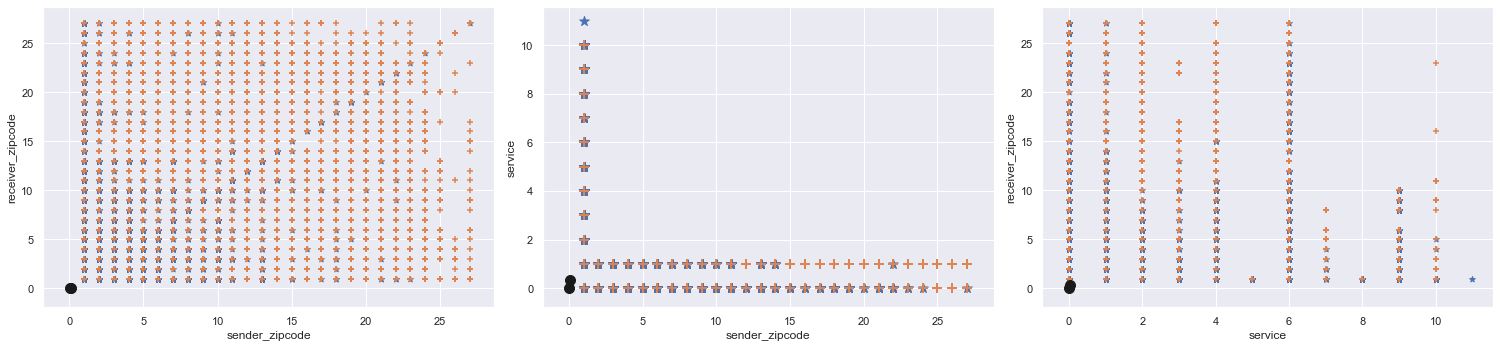

In [165]:
plt.figure(figsize=(20, 10))


target = grouped_zipcodes_df.target == 1

ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(7*ncols, 5*nrows), ncols=3, nrows=1)

ax = axes[0]
ax.scatter(grouped_zipcodes_df[target].sender_zipcode, grouped_zipcodes_df[target].receiver_zipcode, marker='*')
ax.scatter(grouped_zipcodes_df[~target].sender_zipcode, grouped_zipcodes_df[~target].receiver_zipcode, marker='+')
ax.scatter(centers[0][0], centers[0][1], color='k', s=100)
ax.scatter(centers[1][0], centers[1][1], color='k', s=100)
ax.set_xlabel('sender_zipcode')
ax.set_ylabel('receiver_zipcode')

ax = axes[1]
ax.scatter(grouped_zipcodes_df[target].sender_zipcode, grouped_zipcodes_df[target].service, s=100, marker='*')
ax.scatter(grouped_zipcodes_df[~target].sender_zipcode, grouped_zipcodes_df[~target].service, s=100, marker='+')
ax.scatter(centers[0][0], centers[0][2], color='k', s=100)
ax.scatter(centers[1][0], centers[1][2], color='k', s=100)
ax.set_xlabel('sender_zipcode')
ax.set_ylabel('service')

ax = axes[2]
ax.scatter(grouped_zipcodes_df[target].service, grouped_zipcodes_df[target].receiver_zipcode, marker='*')
ax.scatter(grouped_zipcodes_df[~target].service, grouped_zipcodes_df[~target].receiver_zipcode, marker='+')
ax.scatter(centers[0][1], centers[0][2], color='k', s=100)
ax.scatter(centers[1][1], centers[1][2], color='k', s=100)
ax.set_xlabel('service')
ax.set_ylabel('receiver_zipcode')


plt.tight_layout()
plt.show()

7- (*) Cual es el número óptimo de clusters? (Ver método de ​ Elbow​ con KMeans)


In [166]:
KMeans(n_clusters=k).fit(X).cluster_centers_

array([[ 8.64438959e-02,  9.98517000e-03,  1.35608017e-01],
       [ 8.33509542e-02,  3.54830075e-02,  5.49694657e-01],
       [ 4.14238868e-01,  8.98656149e-14,  4.11430185e-02],
       [ 3.08478083e-02,  1.09941223e-02,  1.08237859e-02],
       [ 8.09329199e-02,  3.16094162e-02,  3.29712412e-01],
       [ 4.36799578e-01, -1.22402088e-14,  3.51178620e-01],
       [ 7.26672210e-02,  4.72383130e-01,  2.44263993e-01],
       [ 9.90365772e-02,  4.69710359e-02,  8.08056717e-01],
       [ 6.77447088e-02,  1.77569075e-01,  7.29252094e-02]])

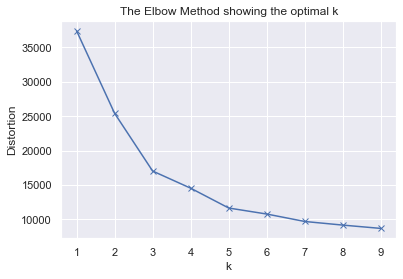

In [29]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


# create new plot and data
plt.plot()
X = df[['sender_zipcode', 'receiver_zipcode', 'service']]
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


8- Describir brevemente las características interesante de los clusters


#### Modelos lineales:
9- Leer sobre accuracy, precision y recall para agregarlas al pool de métricas que vamos a utilizar.


10- Implementar un modelo basado en regresión lineal, calcular las métricas y la matriz de confusión


Para estas pruebas usamos cleaned_df en lugar de grouped_zipcodes_df.Como primer enfoque vamos a tratar 
de encontra alguna relacion lineal entre un solo feature y el target

In [169]:
# but it couldn be useful for you depending on your approach)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

#First aproach: choose only one feature 
selected_feature = 'sender_zipcode'
X = cleaned_df[['sender_zipcode']].copy()
y = cleaned_df[['receiver_zipcode']].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [170]:
linear_reg = LinearRegression().fit(X_train, y_train)

In [171]:
def plot_lineal_regression(X_train_feature, y_train, X_val_feature, y_val):
     
    plt.figure(figsize=(14, 5), dpi= 80, facecolor='w', edgecolor='k')

    X_range_start = np.min(np.r_[X_train_feature, X_val_feature])
    X_range_stop = np.max(np.r_[X_train_feature, X_val_feature])
    y_range_start = np.min(np.r_[y_train, y_val])
    y_range_stop = np.max(np.r_[y_train, y_val])
    X_linspace = np.linspace(X_range_start, X_range_stop, 200).reshape(-1, 1)

    # Conjunto de entrenamiento
    plt.subplot(1, 2, 1)
    plt.scatter(X_train_feature, y_train, facecolor="dodgerblue", edgecolor="k", label="datos")
    plt.plot(X_linspace, linear_reg.predict(X_linspace), color="tomato", label="modelo")
    plt.ylim(y_range_start, y_range_stop)
    plt.title(f"Conjunto de Entrenamiento para feature {selected_feature}")

    # Conjunto de validación
    plt.subplot(1, 2, 2)
    plt.scatter(X_val_feature, y_val, facecolor="dodgerblue", edgecolor="k", label="datos")
    plt.plot(X_linspace, linear_reg.predict(X_linspace), color="tomato", label="modelo")
    plt.ylim(y_range_start, y_range_stop)
    plt.title(f"Conjunto de Validación para feature {selected_feature}")

    plt.show()

    mean_squared_training_error = mean_squared_error(y_train, linear_reg.predict(X_train_feature))
    print(f'Media del error cuadrado para entrenamiento del feature {selected_feature} : {mean_squared_training_error:.2f}')
    
    mean_squared_val_error = mean_squared_error(y_val, linear_reg.predict(X_val_feature))
    print(f'Media del error cuadrado para validación del feature {selected_feature}    : {mean_squared_val_error:.2f}')
    


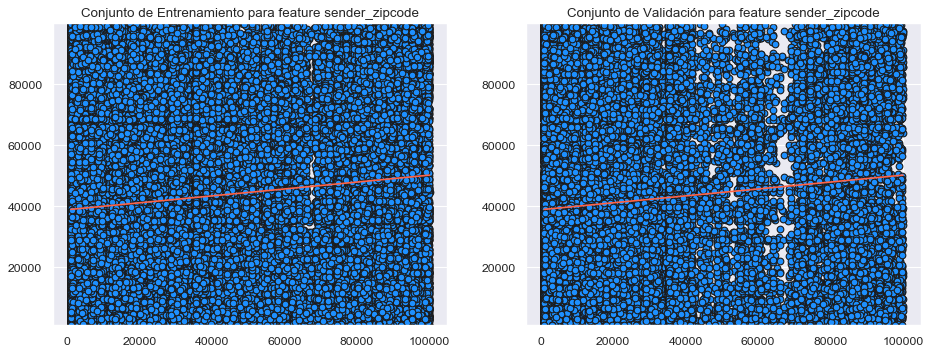

Media del error cuadrado para entrenamiento del feature sender_zipcode : 949044370.16
Media del error cuadrado para validación del feature sender_zipcode    : 946074501.65


In [172]:
plot_lineal_regression(X_train, y_train, X_test, y_test)

Claramente Regresion lineal entre zip code zipcode con los zip codessin agrupar no sirve
Probamos con los zip code agrupados por estados

In [175]:
# but it couldn be useful for you depending on your approach)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

#First aproach: choose only one feature 
selected_feature = 'sender_zipcode'
X = grouped_zipcodes_df[['sender_zipcode']].copy()
y = grouped_zipcodes_df[['receiver_zipcode']].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [176]:
linear_reg = LinearRegression().fit(X_train, y_train)

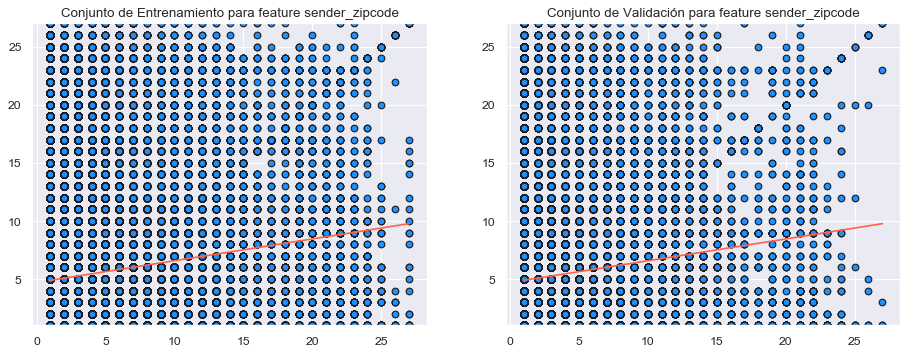

Media del error cuadrado para entrenamiento del feature sender_zipcode : 28.01
Media del error cuadrado para validación del feature sender_zipcode    : 27.99


In [177]:
plot_lineal_regression(X_train, y_train, X_test, y_test)

Nuevamente vemos que no obtenemos informacion aun con los zip codes agrupados por estado
Regresion Lineal no parece servir para este set de datos o tal vez para este conkunto de features

intentaremos un nuevo enfoque con 2 features

In [123]:
linear_reg = LinearRegression().fit(X_train, y_train)

In [179]:
selected_feature = 'sender_zipcode'
X = cleaned_df[['sender_zipcode', 'receiver_zipcode']].copy()
y = cleaned_df[['target']].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [188]:
X = cleaned_df[['sender_zipcode', 'receiver_zipcode']].copy()
y = cleaned_df[['target']].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_reg = LinearRegression().fit(X_train, y_train)

In [190]:
y_pred = linear_reg.predict(X_train)

SIN PLOTEAR LA PREDICCION, POR QUE NO SE COMO HACERLO, SE PUEDE VER QUE LA MAYORIA DE LOS DATOS DE ZIPCODES ESTAN AGRUPADOS
CERCA DE UN TARGET 1

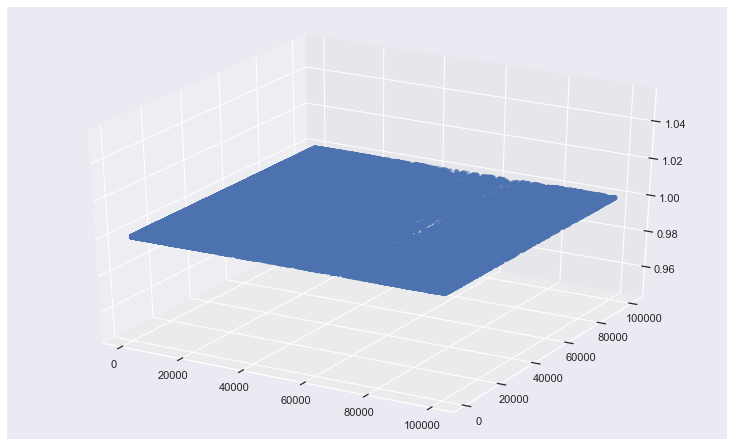

In [193]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure()
ax = Axes3D(fig)

sequence_containing_x_vals =  X_train['sender_zipcode'].values
sequence_containing_y_vals =  X_train['receiver_zipcode'].values
sequence_containing_z_vals =  y_train['target'].values

ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals)
pyplot.show()

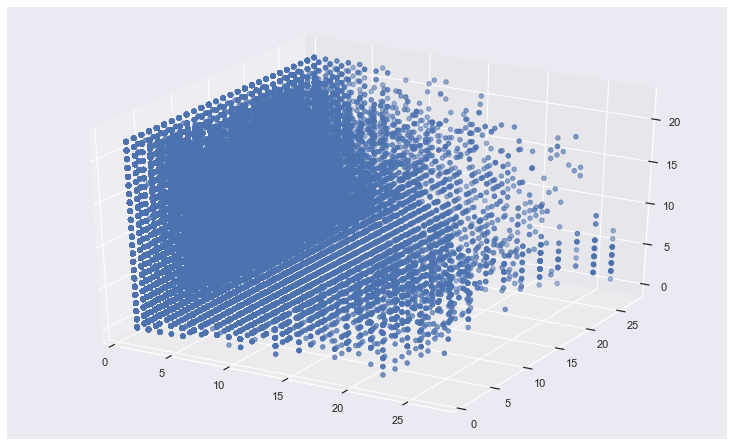

In [194]:
X = grouped_zipcodes_df[['sender_zipcode', 'receiver_zipcode']].copy()
y = grouped_zipcodes_df[['target']].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


fig = pyplot.figure()
ax = Axes3D(fig)

sequence_containing_x_vals =  X_train['sender_zipcode'].values
sequence_containing_y_vals =  X_train['receiver_zipcode'].values
sequence_containing_z_vals =  y_train['target'].values

ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals)
pyplot.show()

In [195]:
CON LOS ZIP CODE AGRUPADOS SE VE UN POCO MAS DE DETALLE EN EL RANGO DE 0-25 (ZIPCODES)
PERO NO PARECE QUE CON REGRESION LINEAL SE PUEDA OBTENER ALGUNA INFORMACION CON ETSOS FEATURES

SyntaxError: invalid syntax (<ipython-input-195-90fa7d171424>, line 1)

11- Implementar un modelo basado en regresión logística, calcular las métricas y la matriz de confusión


In [ ]:
plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')

exploring_params = {
    'learning_rate': ['constant'],
    'eta0': [0.1, 0.01, 0.001],  # Tasa de entrenamiento
    'alpha': [0.1, 0.01, 0.001],  # Tasa de regularización
    'penalty': ['l1','l2'], 
    'C': [0.001,0.01,0.1,1,10,100,1000]
}
cl = SGDClassifier(loss='log', tol=1e-3)
model = GridSearchCV(cl, exploring_params, cv=5, scoring='accuracy')
model.fit(X_train, y_train)

print("# Exploración de hiperparámetros para función de coste \"%s\"" % loss, end="\n\n")

print("Mejor conjunto de parámetros:")
print(model.best_params_, end="\n\n")

print("Puntajes de la grilla:", end="\n\n")
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))
print()

print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")

print("================================================", end="\n\n")

plt.subplot(1, 3, idx)
plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=['0','1'], normalize=True, title="Matriz de confusión para %s" % loss)

In [ ]:
penalty =  'l1'# Tipo de regularización: l1 (valor absoluto), l2 (cuadrados).
alpha = 0.01 # Parámetro de regularización. También denominado como parámetro `lambda`. Debe ser mayor que 0.

model = LogisticRegression(penalty=penalty, C=1./alpha)
model.fit(X_train_feature, y_train)

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train_feature)))
print('Exactitud para validación: %.2f' % accuracy_score(y_val, model.predict(X_val_feature)))

In [ ]:
from sklearn.linear_model import LogisticRegression
logic_reg = LogisticRegression(penalty= 'l1', random_state=0).fit(X_train, y_train)
y_pred = logic_reg.predict(X_test)

12- Cual es la principal diferencia entre estos modelos? Tuviste que hacer algún tipo de post-procesamiento?


13- Estandarizar los features seleccionados y re entrenar los modelos. Las métricas
mejoran? Explicar por qué.
